In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score # AUC score
from sklearn.metrics import average_precision_score # AUPR score
from sklearn.metrics import precision_recall_fscore_support # precision, recall
from imblearn.metrics import sensitivity_specificity_support # sensitivity, specificity
from sklearn.metrics import roc_curve # to draw auc curve
from sklearn.metrics import precision_recall_curve # to draw aupr curve
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [3]:
gold_pos = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/data/desc_12/gold_pos_desc12.tsv")
gold_neg = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/data/desc_12/gold_neg_desc12.tsv")
gold = pd.concat([gold_pos, gold_neg])
x_whole_data = gold[gold.columns.values[3:].tolist()].values
y_whole_data = gold["association"].values

In [4]:
indep = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/data/desc_12/indep_desc12.tsv")
indep_x = indep.values[:, 3:].astype(float)
indep_y = indep.values[:,2].astype(int)

In [5]:
# undersampler
rus = RandomUnderSampler(ratio=0.5)

2017-06-02 22:02:48
0.0001------------------------------------


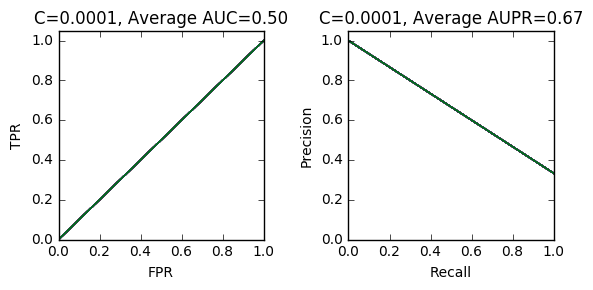

0.001------------------------------------


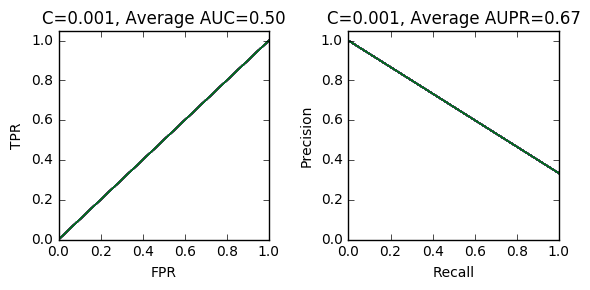

0.01------------------------------------


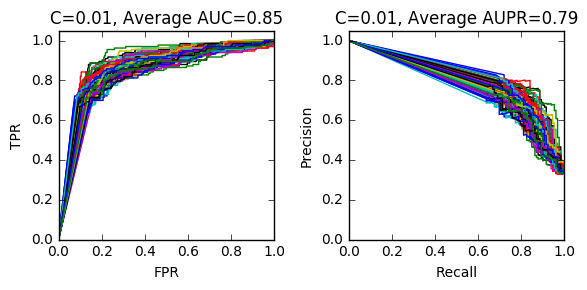

0.1------------------------------------


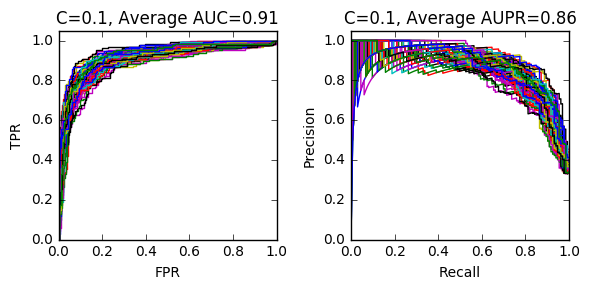

1------------------------------------


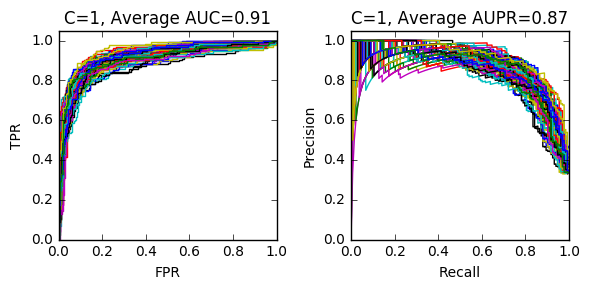

10------------------------------------


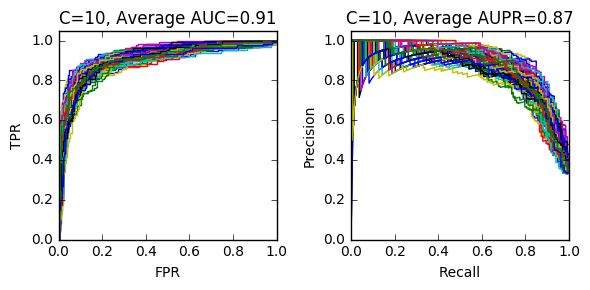

100------------------------------------


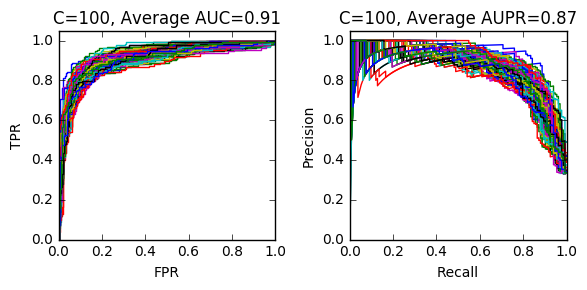

1000------------------------------------


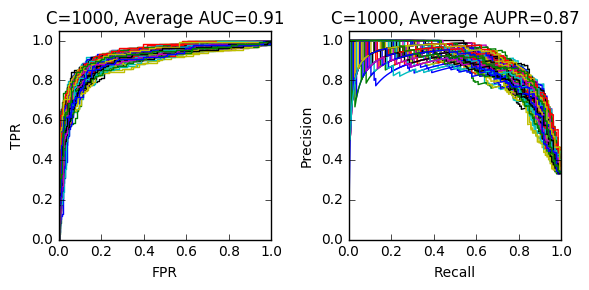

10000------------------------------------


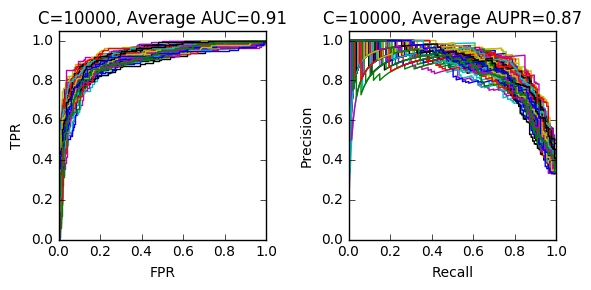

2017-06-02 22:04:44


In [11]:
# LR_K_fold_grpah + 파일 입출력 2017.6.2.
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
all = Trial()
#all.param={'c':0, 'kernel' : 'poly', 'degree' : 2, 'k' : 10, 'tridx' : tridx, 'vaidx' : vaidx}
#all.param={'c':0, 'kernel' : 'poly', 'degree' : 2, 'k' : 10, 'tridxs' : tridxs, 'vaidxs' : vaidxs}
all.param={'c':0, 'kernel' : 'poly', 'degree' : 2, 'k' : 10}
all.param_results = {0.0001:[], 0.001:[], 0.01:[], 0.1:[], 1:[], 10:[], 100:[], 1000:[], 10000:[]}
all.draw_total = {0.0001:[], 0.001:[], 0.01:[], 0.1:[], 1:[], 10:[], 100:[], 1000:[], 10000:[]}
all.final_param_results = {0.0001:[], 0.001:[], 0.01:[], 0.1:[], 1:[], 10:[], 100:[], 1000:[], 10000:[]}
indepndent_count = 10 
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/7_non/'
with open(path + "300_LR_all_desc_training.txt", 'w') as fd :
    fd.write("<10 times independent test : undersampling>\r\n")
    for key in range(indepndent_count):
        all.param['key'] = key
        x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
                all.param['c'] = user_c
                all.folds_results, all.draw_results = all.Logist_Regression_K_fold_graph(x_resampled, y_resampled, all.param)
                all.avg_result = all.average_result(all.folds_results) # parameter 별로 K-fold한 결과와 average를 구한다.
                all.param_results[user_c].append(all.avg_result) # parameter 별로 indepedent 결과 저장한다.
                all.draw_total[user_c].append(all.draw_results)

    for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]: #independent 결과를 parameter별로 평균 낸다.
        all.indep_results = all.independent_results(all.param_results[user_c])
        all.final_param_results[user_c] = all.final_results(all.indep_results)
        all.draw_plot(all.draw_total[user_c],all.final_param_results[user_c], user_c)
        all.write_output(fd, all.final_param_results[user_c], user_c)
    print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

2017-06-02 22:13:27
10000------------------------------------


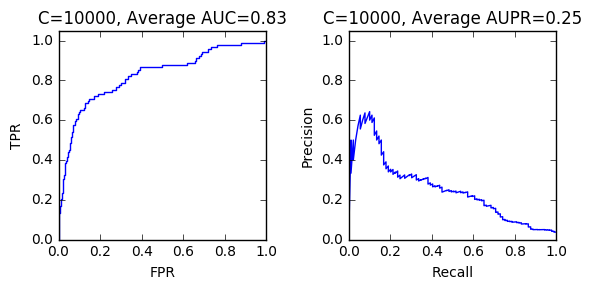

2017-06-02 22:13:27


In [12]:
# Independent LR_K_fold_grpah + 파일 입출력 2017.6.2.
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
#path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/6_combination/'
#path = '/home/share/aschoi/6_combination/'
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/7_non/'
with open(path + "300_LR_all_desc_indep.txt", 'w') as fd :
    user_c = 10000
    all.param['c']=user_c
    fd.write("<independent>\r\n")
    all.indep_folds_results, all.indep_draw_results = all.Logist_Regression_independent_graph(x_resampled, y_resampled, indep_x, indep_y, all.param)
    all.draw_plot([all.indep_draw_results], all.indep_folds_results, user_c)
    all.write_output(fd, all.indep_folds_results, user_c)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

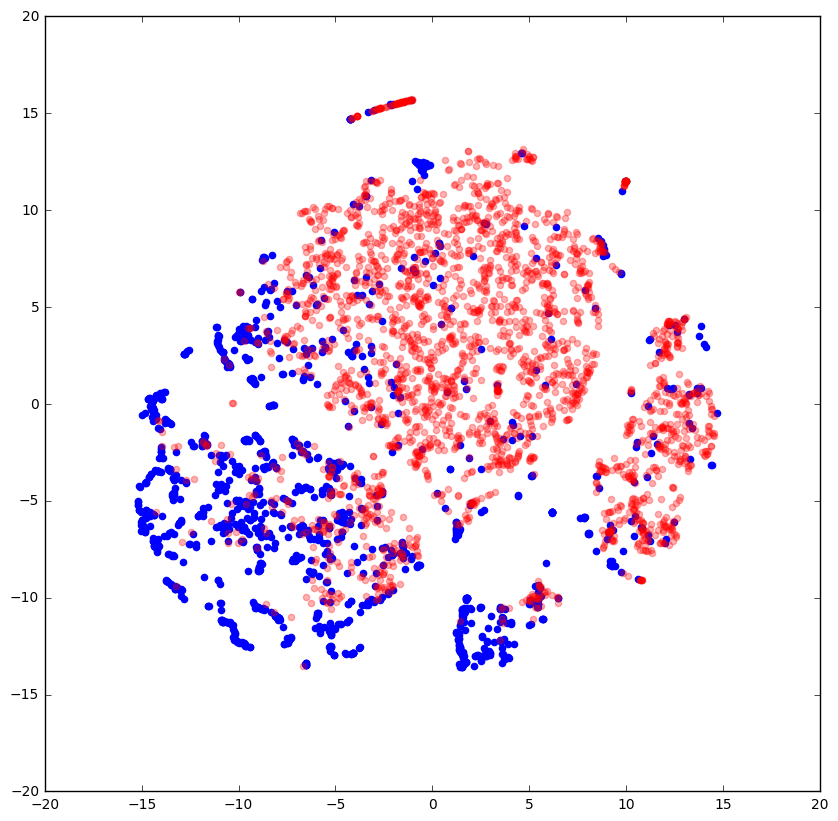

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(x_resampled)
labels = y_resampled
plot_with_labels(low_dim_embs, labels, "300_LR_train.png")

In [14]:
def plot_with_labels(low_dim_embs, labels, filename='temp.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 10))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        if label==1:
            plt.scatter(x, y, color="blue", alpha=1)
        else:
            plt.scatter(x, y, color="red", alpha=0.3)
    plt.savefig(path + filename)
    #plt.show()

2017-06-04 16:17:49


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0001------------------------------------


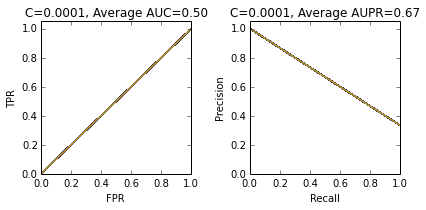

0.001------------------------------------


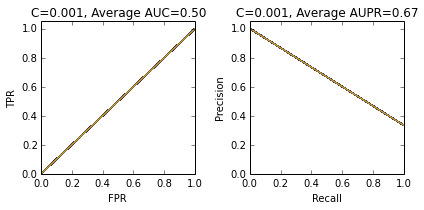

0.01------------------------------------


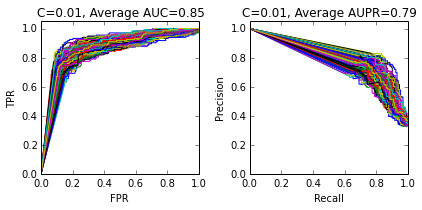

0.1------------------------------------


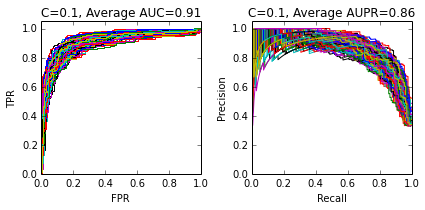

1------------------------------------


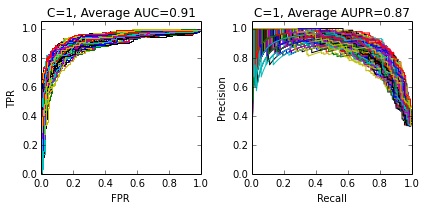

10------------------------------------


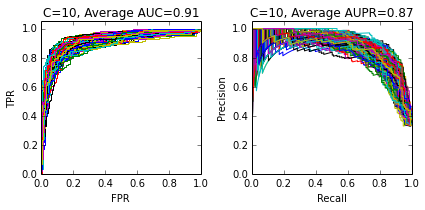

100------------------------------------


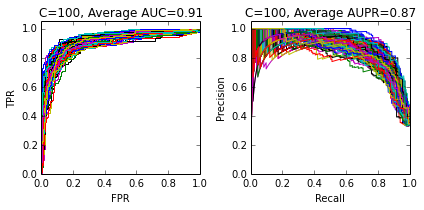

1000------------------------------------


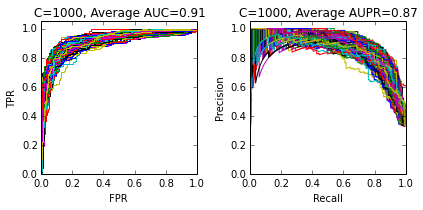

10000------------------------------------


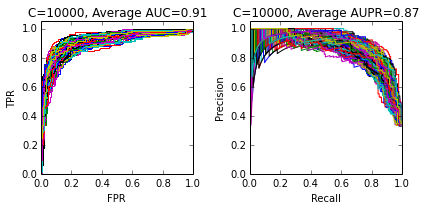

2017-06-04 16:24:02


In [7]:
# LR_K_fold_grpah + 파일 입출력 2017.6.2.
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
all30 = Trial()
#all30.param={'c':0, 'kernel' : 'poly', 'degree' : 2, 'k' : 10, 'tridx' : tridx, 'vaidx' : vaidx}
#all30.param={'c':0, 'kernel' : 'poly', 'degree' : 2, 'k' : 10, 'tridxs' : tridxs, 'vaidxs' : vaidxs}
all30.param={'c':0, 'kernel' : 'poly', 'degree' : 2, 'k' : 10}
all30.param_results = {0.0001:[], 0.001:[], 0.01:[], 0.1:[], 1:[], 10:[], 100:[], 1000:[], 10000:[]}
all30.draw_total = {0.0001:[], 0.001:[], 0.01:[], 0.1:[], 1:[], 10:[], 100:[], 1000:[], 10000:[]}
all30.final_param_results = {0.0001:[], 0.001:[], 0.01:[], 0.1:[], 1:[], 10:[], 100:[], 1000:[], 10000:[]}
indepndent_count = 30
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/7_non/'
with open(path + "301_LR_all30_desc_training.txt", 'w') as fd :
    fd.write("<30 times independent test : undersampling>\r\n")
    for key in range(indepndent_count):
        all30.param['key'] = key
        x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
                all30.param['c'] = user_c
                all30.folds_results, all30.draw_results = all30.Logist_Regression_K_fold_graph(x_resampled, y_resampled, all30.param)
                all30.avg_result = all30.average_result(all30.folds_results) # parameter 별로 K-fold한 결과와 average를 구한다.
                all30.param_results[user_c].append(all30.avg_result) # parameter 별로 indepedent 결과 저장한다.
                all30.draw_total[user_c].append(all30.draw_results)

    for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]: #independent 결과를 parameter별로 평균 낸다.
        all30.indep_results = all30.independent_results(all30.param_results[user_c])
        all30.final_param_results[user_c] = all30.final_results(all30.indep_results)
        all30.draw_plot(all30.draw_total[user_c],all30.final_param_results[user_c], user_c)
        all30.write_output(fd, all30.final_param_results[user_c], user_c)
    print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
10은 못함.
30 파일 저장함.

In [8]:
#draw_plot_to_file(all30.draw_total[1200],all30.final_param_results[1200], user_c, "401_RF_all30_desc_training_1200.png")
#draw_plot_to_file(all30.draw_total[1],all30.final_param_results[1], user_c, "301_LR_all30_desc_training_1.png")
def draw_plot_to_file(draw_results, final_result, user_c, filename):
        #colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
        colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna']
        lw = 1
        plt.clf()
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
        print "{}------------------------------------".format(user_c)
        for i in draw_results:
            for fpr, tpr in zip(i['fpr'], i['tpr']):
                ax1.plot(fpr, tpr, lw=lw)
            for recall_vec, precision_vec in zip(i['recall_vec'], i['precision_vec']):
                ax2.plot(recall_vec, precision_vec, lw=lw)
        ax1.set_xlabel('FPR')
        ax1.set_ylabel('TPR')
        ax1.set_color_cycle(colors)
        ax1.set_title('C={0}, Average AUC={1:0.2f}'.format(user_c, final_result['auc']))
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlim([0.0, 1.0])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_color_cycle(colors)
        ax2.set_title('C={0}, Average AUPR={1:0.2f}'.format(user_c, final_result['aupr']))
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlim([0.0, 1.0])
        plt.tight_layout()
        #plt.show()
        plt.savefig(path + filename)

In [6]:
class Trial :
  
    def Logist_Regression_K_fold_graph(self, X, y, user_parameter):
    
        skf = StratifiedKFold(n_splits=user_parameter['k'], shuffle=True) # n_splits = k (k fold라서.), pos:neg의 비율을 고려해서 k 개의 subgroup으로 나누어줌.
        folds_results = {'acc':[], 'auc':[], 'aupr':[], 'confusion_matrix':[], 'sn':[], 'sp':[], 'precision':[], 'recall':[]}
        draw_results = {'fpr':[], 'tpr':[], 'precision_vec':[], 'recall_vec':[]}
        for training_index, validation_index in skf.split(X, y):           
        #for training_index, validation_index in zip(user_parameter['tridx'], user_parameter['vaidx']):
        #for training_index, validation_index in zip(user_parameter['tridxs'][user_parameter['key']], user_parameter['vaidxs'][user_parameter['key']]):
            x_training_set = X[training_index]
            y_training_set = y[training_index]
            x_validation_set = X[validation_index]
            y_validation_set = y[validation_index]

            #classifier = SVC(C=user_parameter['c'], kernel= user_parameter['kernel'], degree=user_parameter['degree'], probability=True, cache_size=1000) #n_jobs=-1 이면 모든 node 쓰는것, 신경쓰이면 30개 정도.
            classifier = LogisticRegression(penalty='l1', C=user_parameter['c'], n_jobs=-1)
            classifier.fit(x_training_set, y_training_set)

            y_predicted_proba = classifier.predict_proba(x_validation_set) # [0에 대한 확률, 1에 대한 확률], shpae = [n_samples, n_class]
            y_predicted_label = classifier.predict(x_validation_set) # 예측된 label을 보여줌, shpae = [n_samples]

            # Accuracy 
            current_acc = classifier.score(x_validation_set, y_validation_set)
            folds_results['acc'].append(current_acc)

            # AUC
            current_auc = roc_auc_score(y_validation_set, y_predicted_proba[:,1])
            folds_results['auc'].append(current_auc)

            # Sensitivity, Specificity
            sn, sp, support = sensitivity_specificity_support(y_validation_set, y_predicted_label)
            folds_results['sn'].append(sn)
            folds_results['sp'].append(sp)

            # AUPR
            current_aupr = average_precision_score(y_validation_set, y_predicted_proba[:,1])
            folds_results['aupr'].append(current_aupr)

            # Precision, Recall
            precision, recall, _, _ =  precision_recall_fscore_support(y_validation_set, y_predicted_label, average = 'binary')
            folds_results['precision'].append(precision)
            folds_results['recall'].append(recall)

            # Confusion Matrix
            current_confusion_matrix = confusion_matrix(y_validation_set,y_predicted_label)
            folds_results['confusion_matrix'].append(current_confusion_matrix)

            #draw graph
            fpr, tpr, thresholds = roc_curve(y_validation_set, y_predicted_proba[:, 1], pos_label=1)
            draw_results['fpr'].append(fpr)
            draw_results['tpr'].append(tpr)

            precision_vec, recall_vec, _ = precision_recall_curve(y_validation_set, y_predicted_proba[:, 1])
            draw_results['precision_vec'].append(precision_vec)
            draw_results['recall_vec'].append(recall_vec)
        
        return folds_results, draw_results

    def draw_plot(self, draw_results, final_result, user_c):
        #colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
        colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna']
        lw = 1
        plt.clf()
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
        print "{}------------------------------------".format(user_c)
        for i in draw_results:
            for fpr, tpr in zip(i['fpr'], i['tpr']):
                ax1.plot(fpr, tpr, lw=lw)
            for recall_vec, precision_vec in zip(i['recall_vec'], i['precision_vec']):
                ax2.plot(recall_vec, precision_vec, lw=lw)
        ax1.set_xlabel('FPR')
        ax1.set_ylabel('TPR')
        ax1.set_color_cycle(colors)
        ax1.set_title('C={0}, Average AUC={1:0.2f}'.format(user_c, final_result['auc']))
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlim([0.0, 1.0])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_color_cycle(colors)
        ax2.set_title('C={0}, Average AUPR={1:0.2f}'.format(user_c, final_result['aupr']))
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlim([0.0, 1.0])
        plt.tight_layout()
        plt.show()
    def average_result(self, folds_results):
        avg_result = dict()
        avg_result['avg_acc'] = sum(folds_results['acc']) / len(folds_results['acc'])
        avg_result['avg_auc'] = sum(folds_results['auc']) / len(folds_results['auc'])
        avg_result['avg_aupr'] = sum(folds_results['aupr']) / len(folds_results['aupr'])
        avg_result['avg_sn'] = sum(folds_results['sn']) / len(folds_results['sn'])
        avg_result['avg_sp'] = sum(folds_results['sp']) / len(folds_results['sp'])
        avg_result['avg_precision'] = sum(folds_results['precision']) / len(folds_results['precision'])
        avg_result['avg_recall'] = sum(folds_results['recall']) / len(folds_results['recall'])
        avg_result['sum_confusion_matrix'] = sum(folds_results['confusion_matrix'])

        return avg_result


    def independent_results(self, param_result):
        indep_results = {'indep_acc':[], 'indep_auc':[], 'indep_aupr':[], 'indep_confusion_matrix':[],
                         'indep_sn':[], 'indep_sp':[], 'indep_precision':[], 'indep_recall':[]}
        for fold in param_result:
            indep_results['indep_acc'].append(fold['avg_acc'])
            indep_results['indep_auc'].append(fold['avg_auc'])
            indep_results['indep_aupr'].append(fold['avg_aupr'])
            indep_results['indep_sn'].append(fold['avg_sn'])
            indep_results['indep_sp'].append(fold['avg_sp'])
            indep_results['indep_precision'].append(fold['avg_precision'])
            indep_results['indep_recall'].append(fold['avg_recall'])
            indep_results['indep_confusion_matrix'].append(fold['sum_confusion_matrix'])
        return indep_results

    def final_results (self, indep_results):
        results = {'acc':[], 'auc':[], 'aupr':[], 'confusion_matrix':[],
                   'sn':[], 'sp':[], 'precision':[], 'recall':[]}
        results['acc'] = sum(indep_results['indep_acc']) / len(indep_results['indep_acc'])
        results['auc'] = sum(indep_results['indep_auc']) / len(indep_results['indep_auc'])
        results['aupr'] = sum(indep_results['indep_aupr']) / len(indep_results['indep_aupr'])
        results['sn'] = sum(indep_results['indep_sn']) / len(indep_results['indep_sn'])
        results['sp'] = sum(indep_results['indep_sp']) / len(indep_results['indep_sp'])
        results['precision'] = sum(indep_results['indep_precision']) / len(indep_results['indep_precision'])
        results['recall'] = sum(indep_results['indep_recall']) / len(indep_results['indep_recall'])
        results['confusion_matrix'] = sum(indep_results['indep_confusion_matrix'])
        return results

    def final_results (self,indep_results):
        results = {'acc':[], 'auc':[], 'aupr':[], 'confusion_matrix':[],
                   'sn':[], 'sp':[], 'precision':[], 'recall':[]}
        results['acc'] = sum(indep_results['indep_acc']) / len(indep_results['indep_acc'])
        results['auc'] = sum(indep_results['indep_auc']) / len(indep_results['indep_auc'])
        results['aupr'] = sum(indep_results['indep_aupr']) / len(indep_results['indep_aupr'])
        results['sn'] = sum(indep_results['indep_sn']) / len(indep_results['indep_sn'])
        results['sp'] = sum(indep_results['indep_sp']) / len(indep_results['indep_sp'])
        results['precision'] = sum(indep_results['indep_precision']) / len(indep_results['indep_precision'])
        results['recall'] = sum(indep_results['indep_recall']) / len(indep_results['indep_recall'])
        results['confusion_matrix'] = sum(indep_results['indep_confusion_matrix'])
        return results
    def write_output(self, fd, write_results, user_c):
        fd.write("C={}-------------------------------------------------\r\n".format(user_c))
        fd.write("Accuracy avg : {}\r\n".format(write_results['acc']))
        fd.write("AUC avg : {}\r\n".format(write_results['auc']))
        fd.write("  Sensitivity avg : {}\r\n".format(write_results['sn']))
        fd.write("  Specificity avg : {}\r\n".format(write_results['sp']))
        fd.write("AUPR avg : {}\r\n".format(write_results['aupr']))
        fd.write("  Precision avg : {}\r\n".format(write_results['precision']))
        fd.write("  Recall avg : {}\r\n".format(write_results['recall']))
        fd.write("confusion amtrix : {}\r\n".format(write_results['confusion_matrix']))
        
        
        
    def Logist_Regression_independent_graph(self, X, y, indep_X, indep_y, param):

        folds_results = dict()
        draw_results = {'fpr':[], 'tpr':[], 'precision_vec':[], 'recall_vec':[]}

        #classifier = SVC(C=param['c'], kernel= param['kernel'], degree=param['degree'], probability=True, cache_size=1000)
        classifier = LogisticRegression(penalty='l1', C=user_c, n_jobs=-1)
        classifier.fit(X, y)
        indep_y_predicted_proba = classifier.predict_proba(indep_X)
        indep_y_predicted_label = classifier.predict(indep_X)

        # Accuracy
        indep_acc = classifier.score(indep_X, indep_y)
        folds_results['acc']=indep_acc

        # AUC
        indep_auc = roc_auc_score(indep_y, indep_y_predicted_proba[:,1])
        folds_results['auc']=indep_auc

        # Sensitivity, Specificity
        indep_sn, indep_sp, support = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
        folds_results['sn']=indep_sn
        folds_results['sp']=indep_sp

        # AUPR
        indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:,1])
        folds_results['aupr']=indep_aupr

        # Precision, Recall
        indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
        folds_results['precision']=indep_precision
        folds_results['recall']=indep_recall

        # Confusion Matirx
        indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
        folds_results['confusion_matrix']=indep_confusion_matirx

        # draw graph
        indep_fpr, indep_tpr, thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label=1)
        draw_results['fpr'].append(indep_fpr)
        draw_results['tpr'].append(indep_tpr)

        indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
        draw_results['precision_vec'].append(indep_precision_vec)
        draw_results['recall_vec'].append(indep_recall_vec)

        return folds_results, draw_results
    
    def indep_average_result(self, folds_results):
        avg_result = dict()
        avg_result['acc'] = sum(folds_results['acc']) / len(folds_results['acc'])
        avg_result['auc'] = sum(folds_results['auc']) / len(folds_results['auc'])
        avg_result['aupr'] = sum(folds_results['aupr']) / len(folds_results['aupr'])
        avg_result['sn'] = sum(folds_results['sn']) / len(folds_results['sn'])
        avg_result['sp'] = sum(folds_results['sp']) / len(folds_results['sp'])
        avg_result['precision'] = sum(folds_results['precision']) / len(folds_results['precision'])
        avg_result['recall'] = sum(folds_results['recall']) / len(folds_results['recall'])
        avg_result['confusion_matrix'] = sum(folds_results['confusion_matrix'])

        return avg_result

    def seperate_results(self, indep_results):
        temp_results = {'acc':[], 'auc':[], 'aupr':[], 'confusion_matrix':[], 'sn':[], 'sp':[], 'precision':[], 'recall':[]}
        for i in range(independent_count):
            temp_results['acc'].append(indep_results[i]['acc'])
            temp_results['auc'].append(indep_results[i]['auc'])
            temp_results['aupr'].append(indep_results[i]['aupr'])
            temp_results['confusion_matrix'].append(indep_results[i]['confusion_matrix'])
            temp_results['sn'].append(indep_results[i]['sn'])
            temp_results['sp'].append(indep_results[i]['sp'])
            temp_results['precision'].append(indep_results[i]['precision'])
            temp_results['recall'].append(indep_results[i]['recall'])
        return temp_results
